# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [1]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
# from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [2]:
model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "/home/aditya/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/home/aditya/miniconda3/envs/dino/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/aditya/miniconda3/envs/dino/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aditya/miniconda3/envs/dino/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# load coco names
with open('util/defect_coco_names.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

In [5]:
id2name

{1: 'cement_slurry',
 2: 'chipping',
 3: 'exposed_reinforcement',
 4: 'general_uneven',
 5: 'honeycomb',
 6: 'incomplete_deshuttering',
 7: 'moisture_seepage'}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [7]:
args.dataset_file = 'coco'
args.coco_path = "/home/aditya/snaglist_coco-combined/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [8]:
image, targets = dataset_val[0]

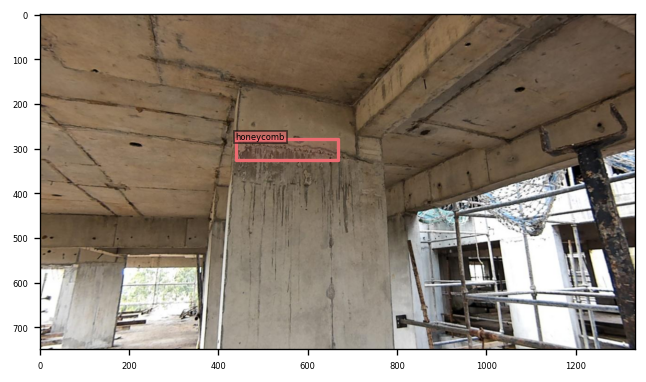

In [13]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [10]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/home/aditya/miniconda3/envs/dino/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
thershold = 0.1 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

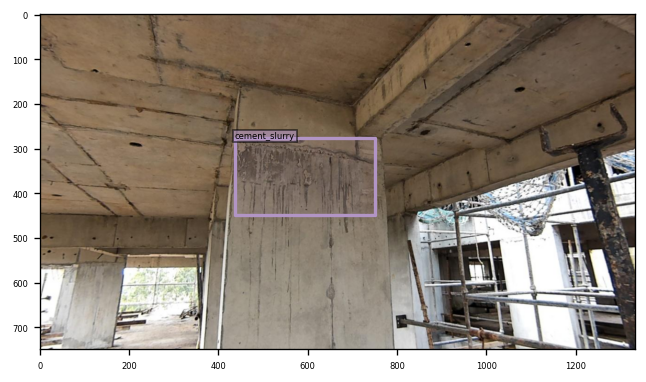

In [15]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [6]:
from PIL import Image
import datasets.transforms as T

In [7]:
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from pycocotools import mask as maskUtils
from matplotlib import transforms

def renorm(img: torch.FloatTensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) \
        -> torch.FloatTensor:
    # img: tensor(3,H,W) or tensor(B,3,H,W)
    # return: same as img
    assert img.dim() == 3 or img.dim() == 4, "img.dim() should be 3 or 4 but %d" % img.dim() 
    if img.dim() == 3:
        assert img.size(0) == 3, 'img.size(0) shoule be 3 but "%d". (%s)' % (img.size(0), str(img.size()))
        img_perm = img.permute(1,2,0)
        mean = torch.Tensor(mean)
        std = torch.Tensor(std)
        img_res = img_perm * std + mean
        return img_res.permute(2,0,1)
    else: # img.dim() == 4
        assert img.size(1) == 3, 'img.size(1) shoule be 3 but "%d". (%s)' % (img.size(1), str(img.size()))
        img_perm = img.permute(0,2,3,1)
        mean = torch.Tensor(mean)
        std = torch.Tensor(std)
        img_res = img_perm * std + mean
        return img_res.permute(0,3,1,2)

class ColorMap():
    def __init__(self, basergb=[255,255,0]):
        self.basergb = np.array(basergb)
    def __call__(self, attnmap):
        # attnmap: h, w. np.uint8.
        # return: h, w, 4. np.uint8.
        assert attnmap.dtype == np.uint8
        h, w = attnmap.shape
        res = self.basergb.copy()
        res = res[None][None].repeat(h, 0).repeat(w, 1) # h, w, 3
        attn1 = attnmap.copy()[..., None] # h, w, 1
        res = np.concatenate((res, attn1), axis=-1).astype(np.uint8)
        return res

class COCOVisualizer():
    def __init__(self) -> None:
        pass

    def visualize(self, img, tgt, caption=None, dpi=120, savedir=None, show_in_console=True):
        """
        img: tensor(3, H, W)
        tgt: make sure they are all on cpu.
            must have items: 'image_id', 'boxes', 'size'
        """
        plt.figure(dpi=dpi)
        plt.rcParams['font.size'] = '5'
        ax = plt.gca()
        img = renorm(img).permute(1, 2, 0)
        ax.imshow(img)
        # plt.
        
        self.addtgt(tgt)
        if show_in_console:
            plt.show()

        if savedir is not None:
            # if caption is None:
            #     savename = '{}/{}-{}.png'.format(savedir, int(tgt['image_id']), str(datetime.datetime.now()).replace(' ', '-'))
            # else:
            #     savename = '{}/{}-{}-{}.png'.format(savedir, caption, int(tgt['image_id']), str(datetime.datetime.now()).replace(' ', '-'))
            savename = '{}'.format(savedir)

            print("savename: {}".format(savename))
            os.makedirs(os.path.dirname(savename), exist_ok=True)
            plt.savefig(savename,bbox_inches='tight')
        plt.close()

    def addtgt(self, tgt):
        """
        - tgt: dict. args:
            - boxes: num_boxes, 4. xywh, [0,1].
            - box_label: num_boxes.
        """
        assert 'boxes' in tgt
        ax = plt.gca()
        H, W = tgt['size'].tolist() 
        numbox = tgt['boxes'].shape[0]

        color = []
        polygons = []
        boxes = []
        for box in tgt['boxes'].cpu():
            unnormbbox = box * torch.Tensor([W, H, W, H])
            unnormbbox[:2] -= unnormbbox[2:] / 2
            [bbox_x, bbox_y, bbox_w, bbox_h] = unnormbbox.tolist()
            boxes.append([bbox_x, bbox_y, bbox_w, bbox_h])
            poly = [[bbox_x, bbox_y], [bbox_x, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y+bbox_h], [bbox_x+bbox_w, bbox_y]]
            np_poly = np.array(poly).reshape((4,2))
            polygons.append(Polygon(np_poly))
            c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
            color.append(c)

        p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.1)
        ax.add_collection(p)
        p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
        ax.add_collection(p)


        if 'box_label' in tgt:
            assert len(tgt['box_label']) == numbox, f"{len(tgt['box_label'])} = {numbox}, "
            for idx, bl in enumerate(tgt['box_label']):
                _string = str(bl)
                bbox_x, bbox_y, bbox_w, bbox_h = boxes[idx]
                # ax.text(bbox_x, bbox_y, _string, color='black', bbox={'facecolor': 'yellow', 'alpha': 1.0, 'pad': 1})
                ax.text(bbox_x, bbox_y, _string, color='black', bbox={'facecolor': color[idx], 'alpha': 0.6, 'pad': 1})

        if 'caption' in tgt:
            ax.set_title(tgt['caption'], wrap=True)




In [9]:
import glob 

images = glob.glob("/home/aditya/edge_fl3/*.jpg")

# prediction=
for image_path in images:
    image = Image.open(image_path).convert("RGB") # load image

    # transform images
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image, _ = transform(image, None)

    output = model.cuda()(image[None].cuda())
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

    thershold = 0.2 # set a thershold

    vslzr = COCOVisualizer()

    scores = output['scores']
    labels = output['labels']
    boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
    select_mask = scores > thershold
    
    box_label = [id2name[int(item)] for item in labels[select_mask]]
    pred_dict = {
        'boxes': boxes[select_mask],
        'size': torch.Tensor([image.shape[1], image.shape[2]]),
        'box_label': box_label
    }
    
    vslzr.visualize(image, pred_dict, savedir=f"/home/aditya/predictions/{image_path.split('/')[-1]}",dpi=100, show_in_console=False)

/home/aditya/miniconda3/envs/dino/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


savename: /home/aditya/predictions/00001045.jpg
savename: /home/aditya/predictions/00004530.jpg
savename: /home/aditya/predictions/00000720.jpg
savename: /home/aditya/predictions/00002332.jpg
savename: /home/aditya/predictions/00002545.jpg
savename: /home/aditya/predictions/00000121.jpg
savename: /home/aditya/predictions/00004414.jpg
savename: /home/aditya/predictions/00002807.jpg
savename: /home/aditya/predictions/00002646.jpg
savename: /home/aditya/predictions/00002348.jpg
savename: /home/aditya/predictions/00002156.jpg
savename: /home/aditya/predictions/00002523.jpg
savename: /home/aditya/predictions/00000658.jpg
savename: /home/aditya/predictions/00004333.jpg
savename: /home/aditya/predictions/00003964.jpg
savename: /home/aditya/predictions/00000730.jpg
savename: /home/aditya/predictions/00001988.jpg
savename: /home/aditya/predictions/00000609.jpg
savename: /home/aditya/predictions/00000341.jpg
savename: /home/aditya/predictions/00002414.jpg
savename: /home/aditya/predictions/00003

In [7]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [ ]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

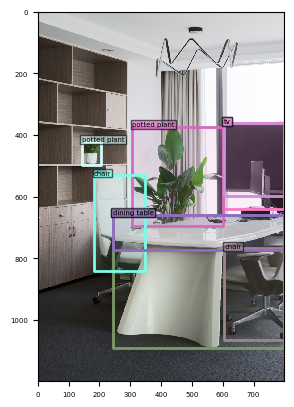

In [9]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir="/home/aditya/val_predictions/", dpi=100)